In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import SelectFromModel


In [2]:
df = pd.read_csv('../../Datasets/Medical_insurance.csv')

## **EDA*

In [3]:
# Cell 2: Basic EDA

# Summary stats
print(df.describe())

# Check missing values
print(df.isnull().sum())



               age          bmi     children       charges
count  2772.000000  2772.000000  2772.000000   2772.000000
mean     39.109668    30.701349     1.101732  13261.369959
std      14.081459     6.129449     1.214806  12151.768945
min      18.000000    15.960000     0.000000   1121.873900
25%      26.000000    26.220000     0.000000   4687.797000
50%      39.000000    30.447500     1.000000   9333.014350
75%      51.000000    34.770000     2.000000  16577.779500
max      64.000000    53.130000     5.000000  63770.428010
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


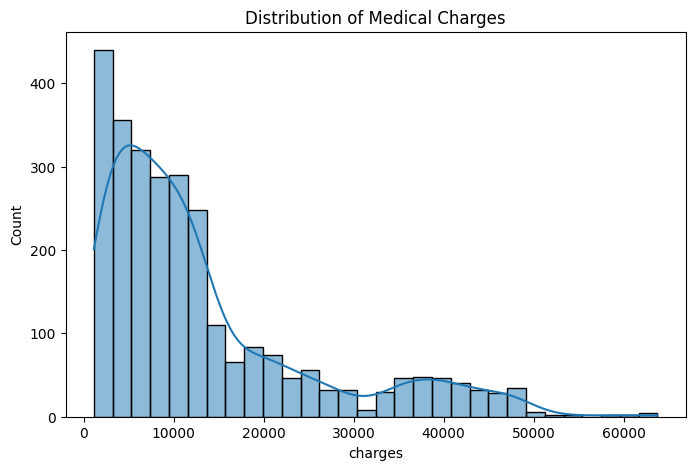

In [4]:

# Visualize distribution of target variable: charges
plt.figure(figsize=(8,5))
sns.histplot(df['charges'], bins=30, kde=True)
plt.title('Distribution of Medical Charges')
plt.show()


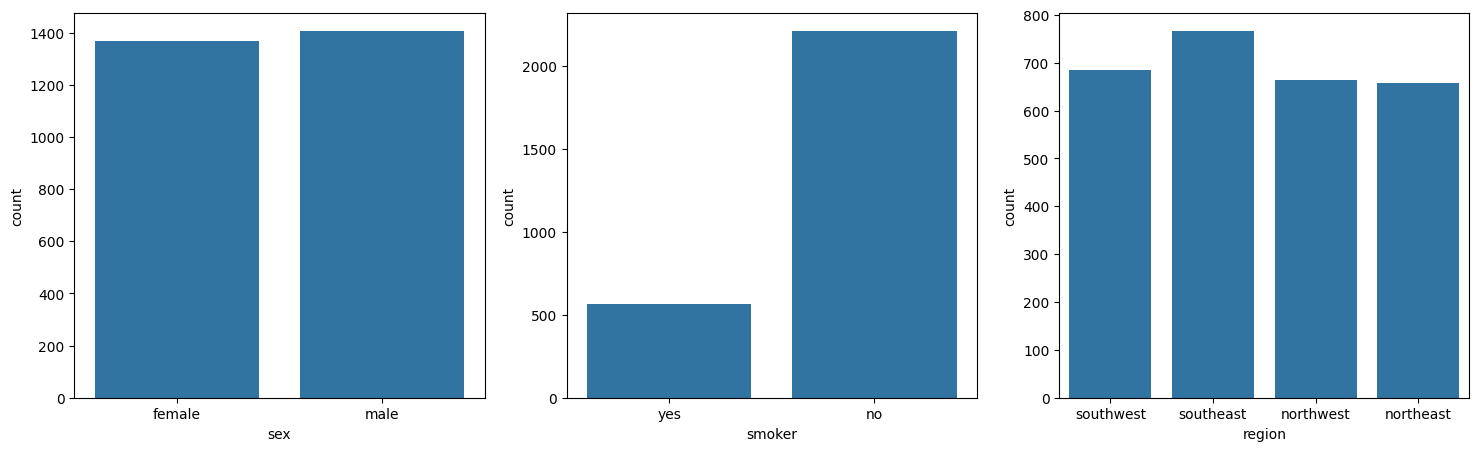

In [5]:

# Visualize categorical features count
fig, axs = plt.subplots(1, 3, figsize=(18,5))

sns.countplot(x='sex', data=df, ax=axs[0])
sns.countplot(x='smoker', data=df, ax=axs[1])
sns.countplot(x='region', data=df, ax=axs[2])
plt.show()


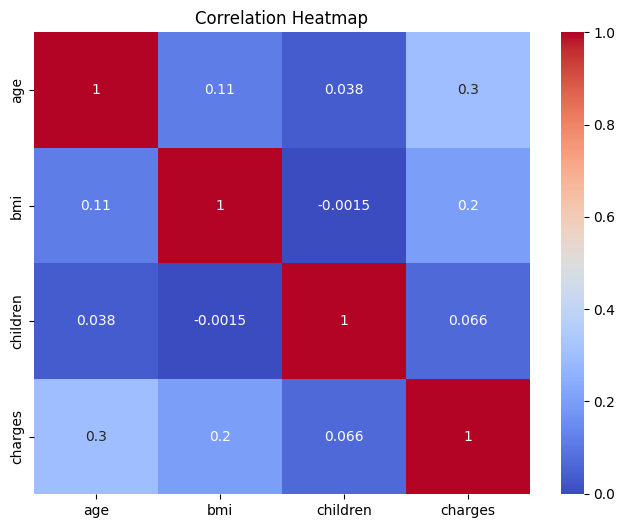

In [6]:

# Correlation heatmap for numeric features
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## **Feature Engineering**

In [7]:
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


In [9]:
df.replace('?' , np.nan , inplace = True )

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


In [11]:
df['charges'] = df['charges'].round(2)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92
1,18,male,33.770,1,no,southeast,1725.55
2,28,male,33.000,3,no,southeast,4449.46
3,33,male,22.705,0,no,northwest,21984.47
4,32,male,28.880,0,no,northwest,3866.86


In [12]:
df['smoker'] = df['smoker'].replace({'yes' : 1 , 'no' : 0 } ).astype(int)
df['sex'] = df['sex'].replace({'male' : 1 , 'female' : 0 } ).astype(int)
df.drop('region' , axis = 1 , inplace = True)

In [13]:
df.head()

,age,sex,bmi,children,smoker,charges
0,19,0,27.900,0,1,16884.92
1,18,1,33.770,1,0,1725.55
2,28,1,33.000,3,0,4449.46
3,33,1,22.705,0,0,21984.47
4,32,1,28.880,0,0,3866.86


(0.0, 66902.85800000001)

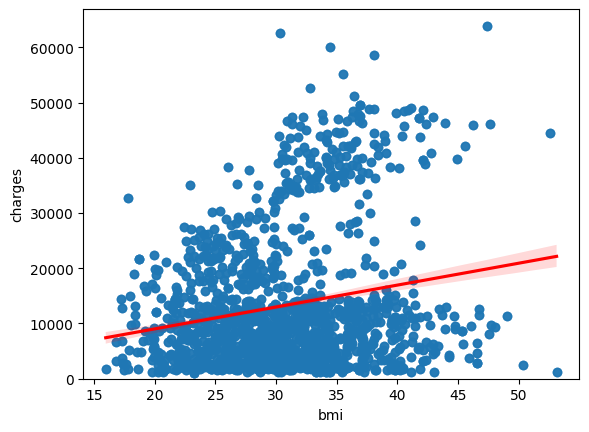

In [14]:
sns.regplot(x="bmi", y="charges", data=df, line_kws={"color": "red"})
plt.ylim(0,)

<Axes: xlabel='smoker', ylabel='charges'>

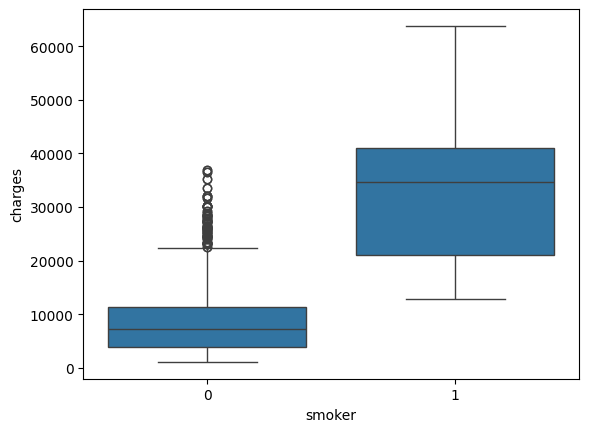

In [15]:
sns.boxplot(data = df , x = 'smoker' , y = 'charges')


<Axes: >

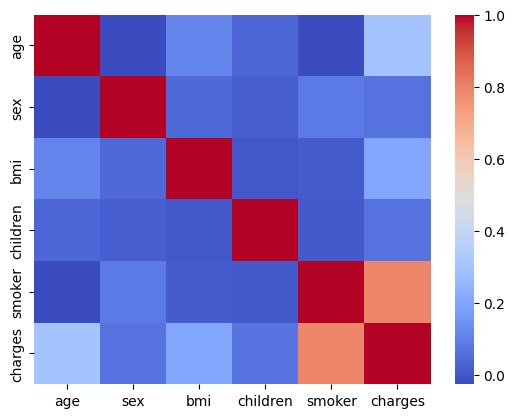

In [16]:
sns.heatmap(df.corr() ,cmap='coolwarm' )


In [17]:
# Cell 3: Preprocessing - Separate features and target, setup transformers

X = df.drop('charges', axis=1)
y = df['charges']

# Identify categorical and numerical columns
cat_features = ['sex', 'smoker']
num_features = ['age', 'bmi', 'children']

# Preprocessing pipelines for numeric and categorical data
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])


## **Splitting Dataset**

In [18]:
# Cell 4: Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (2217, 5), Test shape: (555, 5)


## **Setting Up Linear Regression Model**

In [19]:
# Cell 5: Linear Regression pipeline and training

lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'smoker'])])),
                ('regressor', LinearRegression())])

In [20]:
# Cell 6: Predictions and evaluation for Linear Regression

y_pred_lr = lr_pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_lr)
rmse = mean_squared_error(y_test, y_pred_lr, squared=False)
r2 = r2_score(y_test, y_pred_lr)

print("Linear Regression Performance on Test Set:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")


Linear Regression Performance on Test Set:
MAE: 4502.22
RMSE: 6574.78
R²: 0.718


/home/nahid/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
